In [9]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
%matplotlib inline

In [2]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins)

columns = ['gamma_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 0

gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1

proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
 

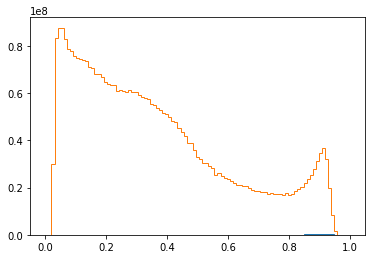

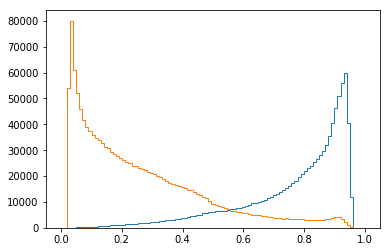

In [3]:
bins = np.linspace(0, 1, 100)
plt.hist(gammas.gamma_prediction_mean, bins=bins, histtype='step', weights=gammas.weight)
plt.hist(protons.gamma_prediction_mean, bins=bins, histtype='step', weights=protons.weight)

plt.figure()
plt.hist(gammas.gamma_prediction_mean, bins=bins, histtype='step', )
plt.hist(protons.gamma_prediction_mean, bins=bins, histtype='step',)
None

In [69]:
def plot_skymap(df):
    az_prediction = df.az_prediction.values * u.rad

    az_prediction = Angle(az_prediction).wrap_at(180*u.deg).deg
    alt_prediction = Angle(df.alt_prediction.values * u.rad).deg
    plt.hist2d(alt_prediction, az_prediction, bins=[np.linspace(65, 75), np.linspace(-5, 5) ], weights=df.weight)
    plt.colorbar()
    plt.gca().set_aspect(1)

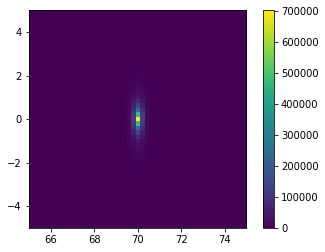

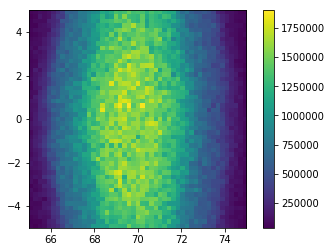

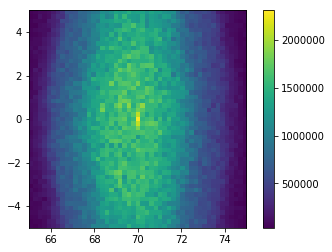

In [70]:
plot_skymap(gammas)
plt.figure()
plot_skymap(protons)
data = gammas.append(protons)
plt.figure()
plot_skymap(data)

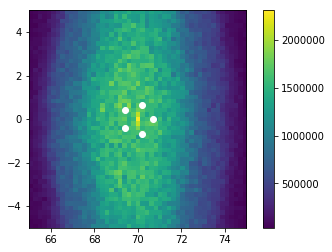

In [75]:
def calc_off_positions(source_alt, source_az, n_off=5):
    alts = []
    azs = []
    for off_index in range(1, n_off+1):
        r = 0.7 * u.deg
        phi = np.arctan2(source_az, source_alt)
        delta_phi = (2 * np.pi / n_off) * u.rad

        alt_off = r * np.cos(phi + off_index * delta_phi) + source_alt
        az_off = r * np.sin(phi + off_index * delta_phi) + source_az
        
        alts.append(alt_off.to(u.deg).value)
        azs.append(az_off.to(u.deg).value)
        
    return alts*u.deg, azs*u.deg

plot_skymap(data)
alt, az = calc_off_positions(70*u.deg, 0*u.deg)
plt.plot(alt, az, 'o', color='white')

In [76]:
def calculate_thetas(data, source_alt=70 * u.deg, source_az=0 * u.deg, n_off=5):
    df = data.copy()
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    df['theta'] = angular_separation(source_az, source_alt, az, alt).to(u.deg).value
    
    alt_offs, az_offs =  calc_off_positions(source_alt, source_az)
    for i, (p_alt, p_az) in enumerate(zip(alt_offs, az_offs), start=1):
        source_az = Angle(p_az).wrap_at(180 * u.deg)
        source_alt = Angle(p_alt)

        az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
        alt = Angle(df.alt_prediction.values, unit=u.rad)

        df[f'theta_off_{i}'] = angular_separation(p_az, p_alt, az, alt).to(u.deg).value

    return df

data = calculate_thetas(data)
gammas = calculate_thetas(gammas)
protons = calculate_thetas(protons)

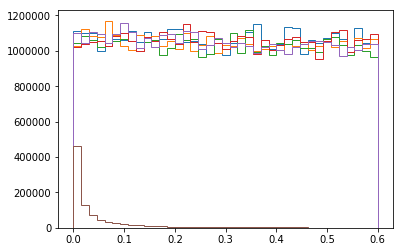

In [77]:
for i in range(1, 6):
    plt.hist(protons[f'theta_off_{i}']**2, bins=np.linspace(0, 0.6, 40), histtype='step', weights=protons.weight * 0.2)
    
plt.hist(gammas.theta**2, bins=np.linspace(0, 0.6, 40), histtype='step')
None

In [81]:
def split_on_off(data, theta2_cut=0.03):
    # apply theta2_cut
    theta_cut = np.sqrt(theta2_cut)
    on_data = data.query(f'theta <= {theta_cut}')

    off_keys = ['theta_off_1', 'theta_off_2', 'theta_off_3', 'theta_off_4', 'theta_off_5']
    off_dfs = []
    for region, theta_off_key in enumerate(off_keys, start=1):
        off_df = data.query(f'{theta_off_key} <= {theta_cut}').copy()
        off_df['off_region'] = region
        off_dfs.append(off_df)

    off_data = pd.concat(off_dfs)

    return on_data, off_data

on_data, off_data = split_on_off(data, theta2_cut=0.01)

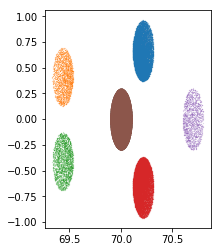

In [85]:
for i in range(1, 6):
    df = off_data.query(f'off_region == {i}')
    
    az_prediction = df.az_prediction.values * u.rad

    az_prediction = Angle(az_prediction).wrap_at(180*u.deg).deg
    alt_prediction = Angle(df.alt_prediction.values * u.rad).deg
    
    plt.scatter(alt_prediction, az_prediction, s=0.01)
    
    
az_prediction = on_data.az_prediction.values * u.rad

az_prediction = Angle(az_prediction).wrap_at(180*u.deg).deg
alt_prediction = Angle(on_data.alt_prediction.values * u.rad).deg

plt.scatter(alt_prediction, az_prediction, s=0.01)
plt.gca().set_aspect(1)

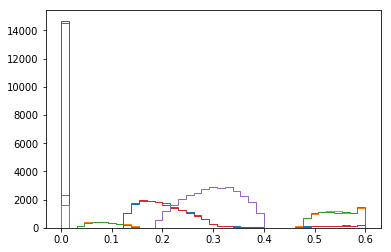

In [83]:
for i in range(1, 6):
    plt.hist(off_data[f'theta_off_{i}']**2, bins=np.linspace(0, 0.6, 40), label='on', histtype='step')

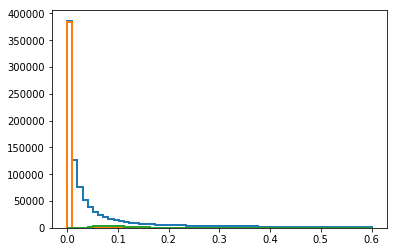

In [102]:
plt.hist(data.theta**2, bins=np.linspace(0, 0.6, 60), histtype='step', lw=2)
plt.hist(on_data.theta**2, bins=np.linspace(0, 0.6, 60), histtype='step', lw=2)
plt.hist(off_data.theta**2, bins=np.linspace(0, 0.6, 60), histtype='step', lw=2)
None

In [91]:
alpha = 0.2
on_data.weight.sum(), off_data.weight.sum() * alpha

(4892018.665102262, 3568873.163299923)

In [99]:
def significance_after_cuts(data, signal_region, prediction_threshold):
    m = ((data.theta**2 < signal_region) & (data.gamma_prediction_mean >= prediction_threshold))
    n_on = data[m].weight.sum()

    m = ((data.theta**2 < signal_region) & (data.type == 1) & (data.gamma_prediction_mean >= prediction_threshold))
    n_off = data[m].weight.sum()

    s = li_ma_significance(n_on, n_off, alpha=1)
    return s, n_on, n_off


def find_best_n(data, regions=slice(0.03, 0.031, 0.005), thresholds=slice(0., 1, 0.1)):
    target = lambda x, d: -significance_after_cuts(d, x[0], x[1])[0]
    result = brute(target, ranges=[regions, thresholds], args=(data, ), finish=None)
    s, n_on, n_off = significance_after_cuts(data, *result)
    print(s, result)
    return n_on, n_off


def target(H, n_on, n_off, sigma=5):
    n_excess = n_on - n_off
    n_on_prime = n_off + n_excess * H
    return (5 - li_ma_significance(n_on=n_on_prime, n_off=n_off, alpha=1))**2


def scaling_factor(n_on, n_off, N=100): 
    print(n_on, n_off)
    n_on = np.random.poisson(int(n_on), size=100)
    n_off = np.random.poisson(int(n_off), size=100)
    
    hs = []
    for on, off in zip(n_on, n_off):
        h = minimize_scalar(target, args=(on, off), bounds=(0, 3), method='bounded').x
        hs.append(h)
    return np.array(hs).mean()

# def calc_relative_sensitivity(data, bin_edges, optimize=False):
#     relative_sensitivities = []
#     for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
#         m = ((data.mc_energy > e_low ) & (data.mc_energy < e_high ))
#         selected_data = data[m]
#         if optimize:
#             n_on, n_off = find_best_n(selected_data)
#         else:
#             _, n_on, n_off = significance_after_cuts(selected_data, signal_region=0.03, prediction_threshold=0.75)
        
#         relative_sensitivities.append(scaling_factor(n_on, n_off))
#     return np.array(relative_sensitivities)


def calc_relative_sensitivity(data, bin_edges, optimize=False):
    relative_sensitivities = []
    for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
        m = ((data.mc_energy > e_low ) & (data.mc_energy < e_high ))
        selected_data = data[m]
        
        on_data, off_data = split_on_off(selected_data, theta2_cut=0.01)
        n_on = on_data.weight.sum()
        n_off = off_data.weight.sum() * 0.2
        relative_sensitivities.append(scaling_factor(n_on, n_off))
    return np.array(relative_sensitivities)

In [100]:
def plot_sensitivity(rs, crab, bin_edges, bin_center):
    sensitivity = rs * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle=''); plt.xscale('log') ; plt.yscale('log')

246826.66779223588 164484.23145055468
555435.2522974358 311307.6715597563
642986.2010343742 455341.22447075613
646742.085209387 514660.3785713116
798127.7028569921 562967.4647779375
642848.5197116038 486357.3082938478
414112.69137718424 388311.36183509754
278823.70777558 217038.3867168164
210997.30400759366 154016.59234847364
142383.79418690712 104981.09173377785
87528.86029666403 59904.82798694987
43903.43568031608 40018.28497514968
24911.671196917872 19724.149119555444
8690.064853093412 10419.286624890916
4439.467265926788 3940.24461500424
2577.690472782179 1621.7054262428583
2279.848772144271 702.7359386731256
778.2279226288879 543.2527815851457
162.99403397609228 330.51768636711216
210.39900359054093 157.02965314415067


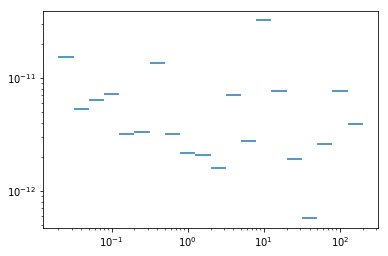

In [101]:
rs = calc_relative_sensitivity(data, bin_edges)
plot_sensitivity(rs, crab, bin_edges, bin_center)
# rs = calc_relative_sensitivity(data, bin_edges, optimize=False)
# plot_sensitivity(rs, crab, bin_edges, bin_center)